# 14. Mixing Python and Fiji

There are many tools to do image processing and data analysis, and all have their strengths and weaknesses, and ideally we should be able to combine them, and notebooks are an ideal playground for this. Here we focus on the possibility to use Fiji in the notebook environment. There are two possibilities: one can create notebooks to run exclusively Fiji or one can mix Python and Fiji in a notebook.

For exclusive Fiji notebooks we encourage you to check the [extensive documentation](https://github.com/imagej/tutorials/tree/master/notebooks) available online from the Fiji community. You will find multiple notebooks there with extensive examples. As this is a Python course, we are going here to focus on the second aspect: how can we mix the Python and Fiji worlds. You can find a more complete description in [this notebook](https://nbviewer.jupyter.org/github/imagej/tutorials/blob/master/notebooks/1-Using-ImageJ/6-ImageJ-with-Python-Kernel.ipynb). We drew a lot of information from the latter notebook for this shorter overview.

The possibility to "import" Fiji into Python is provided by the [Pyimagej](https://github.com/imagej/pyimagej) package. It offers various tools to exchange information betwee both worlds.

## 14.1 Importing Fiji

In order to have access to Fiji in the notebook, we need to import it first. This is done via the ```imagej``` pacakge and the function ```imagej.init()```. There are multiple ways to call it, allowing you to choose whether to install Imagej, Fiji, plugins, specific versions etc. You can check the table provided in [this notebook](https://github.com/imagej/tutorials/blob/master/notebooks/1-Using-ImageJ/6-ImageJ-with-Python-Kernel.ipynb) for details. Here we suggest only two possibilities:
- ```ij = imagej.init('sc.fiji:fiji:2.0.0-pre-10')``` to import a specific version of Fiji including plugins
- ```ij = imagej.init('/Applications/Fiji.app')``` to import your local installation of Fiji if you run the notebook on your own computer (not Binder or Colab).

In the latter case, if you use a remote environment (Linux), you can download the most recent version of Fiji like this:
```bash
%%bash
wget https://downloads.imagej.net/fiji/latest/fiji-linux64.zip
apt install unzip
unzip fiji-linux64.zip
```

In [1]:
import imagej
ij = imagej.init('sc.fiji:fiji:2.0.0-pre-10')
#ij = imagej.init('/Applications/Fiji.app')
ij.getVersion()

'2.0.0-rc-71/1.52i'

We also import skimage and matplotlib to show how we can mix the two image processing environments:

In [2]:
import skimage
from skimage import io
import skimage.filters
import skimage.morphology
import matplotlib.pyplot as plt
import numpy as np

## 14.2 Re-using macros

Let's imagine the following situation: you developed a macro (e.g. using the macro recorder) to segmen 

To run macros, you need to use the ```ij.py.run_macro``` command. You can essentially copy/paste the content of the macro recorder in the function, and it will run that command. For example if we do ```File -> Open Samples -> Blobs(25K)``` in Fiji it will record the command  ```run("Blobs (25K)");```. Now we copy:

In [3]:
ij.py.run_macro("""run("Blobs (25K)");""");

We are using Fiji in headless mode here, so no image is appearing but it "exists" in the background. To pull recover it we need access to Fiji's WindowManager, and thus have to import that class:

In [4]:
from jnius import autoclass
WindowManager = autoclass('ij.WindowManager')

In [5]:
blobs = WindowManager.getCurrentImage()
blobs

<ij.ImagePlus at 0x13c9b2c50 jclass=ij/ImagePlus jself=<LocalRef obj=0x7fd1f0c43c98 at 0x130a30f70>>

We see that the output is not a numpy array but a Java object. We can use a utility from pyimagej that converts and displays the image for us:

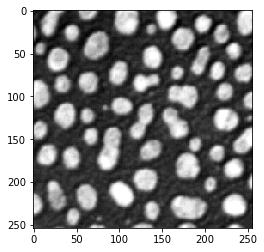

In [6]:
ij.py.show(blobs, cmap = 'gray')

Alternatively we can also manually convert the Java image into a numpy array to display it. For that we need to transfer the image from the "java-world" to the "numpy-world" using ```ij.py``` utilities:

In [7]:
type(blobs)

jnius.reflect.ij.ImagePlus

In [8]:
blob_np = ij.py.from_java(blobs)
type(blob_np)

numpy.ndarray

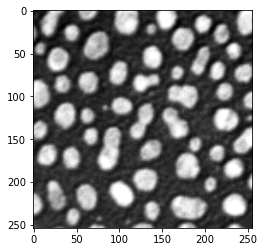

In [9]:
plt.imshow(blob_np, cmap = 'gray');

We can also send the numpy array back the Java for further Fiji processing:

In [10]:
blob_back = ij.py.to_java(blob_np)
type(blob_back)

jnius.reflect.net/imglib2/python/ReferenceGuardingRandomAccessibleInterval

Of course, just as in Fiji, we can run multiple macro commands. Since we don't see the image, you just have to imagine that each command operates on the current image. For example we can import an image and then blur it with a Gaussian filter:

In [11]:
ij.py.run_macro("""run("Blobs (25K)");""");

In [12]:
ij.py.run_macro("""run("Gaussian Blur...", "sigma=10");""");

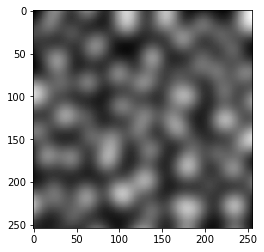

In [13]:
result = WindowManager.getCurrentImage()
ij.py.show(result, cmap = 'gray')

Finally, we can combine all steps in a single macro command. We can even pass arguments using the ```args``` option. For example here we pass the Gaussian width as an argument. Note that this variable has to be "declared" in the macro too:

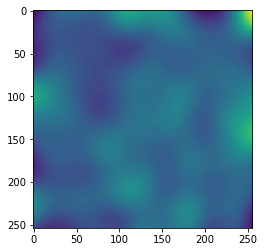

In [14]:
macro = """
#@ int sigma
run("Blobs (25K)");
run("Gaussian Blur...", "sigma=" + sigma);
"""
args = {
    'sigma': 20,
}
ij.py.run_macro(macro, args);
result = WindowManager.getCurrentImage()
ij.py.show(result)

Ans we can use this as regular Python code, e.g. to see the results by varying sigma:

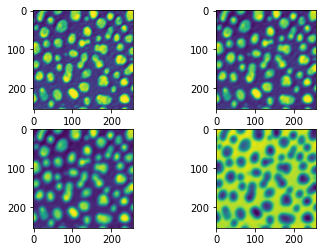

In [15]:
images = []
for s in range(1,5):
    args['sigma'] = s
    ij.py.run_macro(macro, args);
    result = WindowManager.getCurrentImage()
    images.append(ij.py.from_java(result))

fig = plt.figure()
for i in range(1,5):
    ax = fig.add_subplot(2, 2, i)
    ax.imshow(images[i-1])

## 14.3 Complete workflows

The possibility to combine Fiji macros and Python code (and don't forget you can use also more advanced features like ImageJ ops) allows us to create complete workflows from data import to publication ready plots. This is possible thanks to Python's strength in data analysis compared to the Fiji environment.

We illustrate this with an analysis, where we want to determine the effect of blurring on the final size of detected blobs (obviously we don't need Fiji for a simple blurring, but this is meant as an example). We will run the blurring via a Fiji macro and then recover the image, analyze the objects with skimage and finally analyze data with Pandas and Matplotlib:

In [16]:
import pandas as pd

all_regions = []
for s in range(1,15,3):
    # adjust sigma value
    args['sigma'] = s
    
    # run macro and recover image
    ij.py.run_macro(macro, args);
    result = WindowManager.getCurrentImage()
    image = ij.py.from_java(result)
    
    # do thresholding and region analysis with skimage
    image_th = image > skimage.filters.threshold_otsu(image)
    regions = skimage.measure.regionprops_table(skimage.morphology.label(image_th),
                                                properties=('label','area'))
    regions['sigma'] = s
    all_regions.append(pd.DataFrame(regions))

# assemble resluts in single dataframe
analyzed = pd.concat(all_regions)

# use Pandas to calculate some statistics
result = analyzed.groupby('sigma').mean().reset_index()

In [17]:
result

,sigma,label,area
0,1,31.5,356.322581
1,4,29.5,370.051724
2,7,20.5,578.750000
3,10,13.0,1036.160000
4,13,8.5,1631.187500


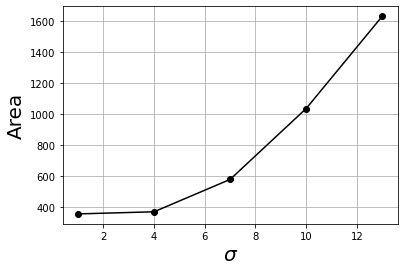

In [18]:
fig, ax = plt.subplots()
ax.plot(result.sigma, result.area,'-ok')
ax.set_xlabel('$\sigma$', fontdict= {'fontsize':20})
ax.set_ylabel('Area', fontdict= {'fontsize':20});
ax.grid(True)